<a href="https://colab.research.google.com/github/brahma2024/Deep-Implicit-Layers/blob/main/Ch1_0_Deep_Implicit_Layer_Fixed_point_through_Naive_Forward_Iterations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Implicit Layer Tutorial

- **Implementing a fixed point iteration layer**
- Naive Forward Iterations https://en.wikipedia.org/wiki/Fixed-point_iteration

In [ ]:
import torch
import torch.nn as nn
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:
class TanhFixedPointLayer(nn.Module):
  def __init__(self, out_features, tolerance = 1e-4, max_iters = 50):
    super().__init__()
    self.linear = nn.Linear(out_features, out_features, bias=False)
    self.tolerance = tolerance
    self.max_iters = max_iters
    self.iteration = 0 # just to keep count of when the iterations break and print

  def forward(self, x):
    # forward method builds the computation graph

    # initialize output z to be zero
    z = torch.zeros_like(x)
    # z = torch.tanh(x)
    errs_stepwise = []

    # iterate until convergence
    for i in range(self.max_iters):
      z_next = torch.tanh(self.linear(z) + x)
      self.err = torch.norm(z - z_next) # using default Frobenius norm (default, same as L2 norm for matrices)
      # The norm is a measure of the magnitude of a tensor, and there are different types of norms,
      # such as L1 norm (Manhattan distance), L2 norm (Euclidean distance), and others
      errs_stepwise.append(self.err)

      z = z_next

      if i % 5 == 0:
        print(f"iteration/max_ters: {i:d}/{self.max_iters:d} | err = {self.err:.7f}")

      if self.err < self.tolerance:
        self.iteration = i
        break

    return z, errs_stepwise

In [ ]:
# run the above layer on a random output, to see that in reaches a fixed point
layer = TanhFixedPointLayer(50)
X = torch.randn(10, 50)
print(X.shape)
Z, errs = layer(X)
print(f'Terminated after {layer.iteration} iterations with error {layer.err}')

torch.Size([10, 50])
iteration/max_ters: 0/50 | err = 14.0520859
iteration/max_ters: 5/50 | err = 0.1261329
iteration/max_ters: 10/50 | err = 0.0016340
Terminated after 14 iterations with error 6.48750428808853e-05


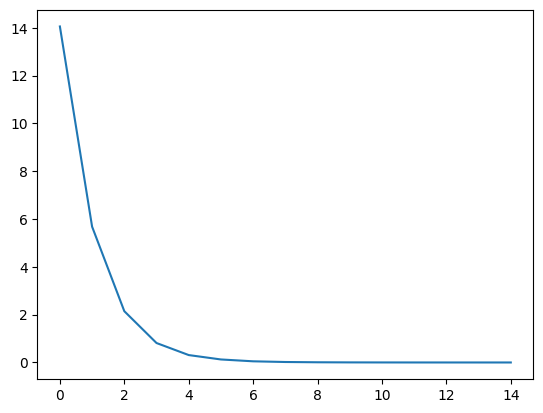

In [ ]:
plt.plot([err.detach().numpy() for err in errs])

# Simple model trained on the MNIST dataset,
- using a single fixed point layer
- with an additional linear input layer before the fixed point layer, and
- linear layer after the fixed point layer

# Objective:
- the network at least trains with this layer

In [ ]:
# import the MINST dataset and data loaders
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# download the MNIST dataset from torchvision.datasets
mnist_train = datasets.MNIST(".", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(".", train=False, download=True, transform=transforms.ToTensor())

# create a DataLoader
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5210003.89it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 153327.98it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:05<00:00, 299165.76it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6945143.55it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
device

device(type='cpu')

# **The MNIST dataset**

consists of images of handwritten digits (0-9), and each image is represented as a tensor in PyTorch. Let's break down the components of the shape torch.Size([1, 28, 28]):

**Components of the Shape**
1.   1 (Number of Channels):
The first dimension indicates the number of channels in the image. For MNIST, the images are grayscale, meaning they only have one channel. This is different from RGB images, which have three channels (Red, Green, and Blue).
2.   28 (Height):
The second dimension represents the height of the image in pixels.
Each MNIST image is 28 pixels tall.
3. 28 (Width):
The third dimension represents the width of the image in pixels.
Each MNIST image is 28 pixels wide.


**What the Tensor Stores**

The tensor stores pixel values for the image.
Since the images are grayscale, each pixel value is a single intensity value ranging from 0 to 255. In the context of the 'transforms.ToTensor()' transformation, these values are normalized to the range [0, 1].

In [ ]:
# reviewing the dataset
print(f"{len(mnist_train)=} | {type(mnist_train[0])=}") # MNIST dataset has images + labels stored as tuple
image, label = mnist_train[0]
print(f'{type(image)=} | {image.shape=}')
print(f'{type(label)=} | {label}')

label_list = []
for i in range(len(mnist_train)):
  label_list.append(mnist_train[i][1])

label_list = sorted(list(set(label_list)))
print(label_list)

len(mnist_train)=60000 | type(mnist_train[0])=<class 'tuple'>
type(image)=<class 'torch.Tensor'> | image.shape=torch.Size([1, 28, 28])
type(label)=<class 'int'> | 5
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Shape of image tensor: torch.Size([1, 28, 28])


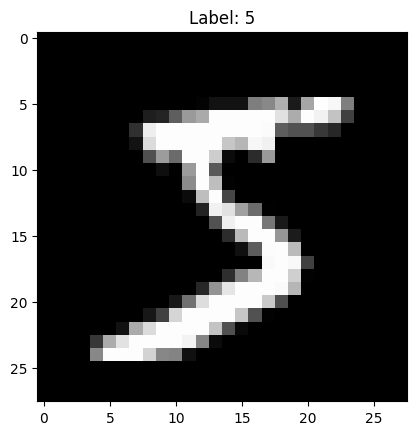

In [ ]:
# visualize what the tensor stores
# Load the MNIST dataset
mnist_train = datasets.MNIST(".", train=True, download=True, transform=transforms.ToTensor())

# Access the first element (a tuple of (image, label))
image, label = mnist_train[0]

# Display the shape of the tensor
print(f"Shape of image tensor: {image.shape}")

# Convert the tensor to a numpy array and display the image
image_np = image.squeeze().numpy()  # Remove the channel dimension for visualization
plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {label}")
plt.show()


In [ ]:
# rewriting the TanhFixedPointLayer class to return a tensor z and not a tuple z, err
class TanhFixedPointLayer1(nn.Module):
  def __init__(self, out_features, tolerance = 1e-4, max_iters = 50):
    super().__init__()
    self.linear = nn.Linear(out_features, out_features, bias=False)
    self.tolerance = tolerance
    self.max_iters = max_iters
    self.iterations = 0

  def forward(self, x):
    # forward method builds the computation graph

    # initialize output z to be zero
    z = torch.zeros_like(x)
    # z = torch.tanh(x)

    # iterate until convergence
    for _ in range(self.max_iters):
      z_next = torch.tanh(self.linear(z) + x)

      if torch.norm(z - z_next) < self.tolerance:
        break

      z = z_next
      self.iterations += 1

    return z

In [ ]:
# construct a simple model with fixed point layer
import torch.optim as optim

torch.manual_seed(0)
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(784, 100),

                      # TanhFixedPoint Layer: # input (x) to this layer is previous layers output
                      # this cell trains on the output of previous layer to find a fixed point
                      # after tqdm iterations, we should finally have weights (which are shared by all layers) which can provide us a fixed point
                      TanhFixedPointLayer1(100, max_iters=200),
                      nn.Linear(100, 10)
                      ).to(device)

opt = optim.SGD(model.parameters(), lr=1e-1)
for p in model.parameters():
  print(p.nelement())

78400
100
10000
1000
10


In [ ]:
# a generic function for running a single epoch (training or evaluation)
from tqdm.notebook import tqdm

def epoch(loader, model, opt=None, monitor=None):
  total_loss, total_err, total_monitor = 0., 0., 0.

  # initialize a loss function
  # criterian = nn.CrossEntropyLoss() # This is an object-oriented approach where you create an instance of the loss function and then call it with your predictions and targets.
  model.eval() if opt is None else model.train()

  # tqdm is a Python library that provides a fast, extensible progress bar for loops and other iterable processes
  # tqdm iterates over the data loader
  # train_loader has mnist_dataset_size = 60000 and batch_size = 100
  for X, y in tqdm(loader, leave=False):
    X, y = X.to(device), y.to(device) # move data and labels to the specified device

    # Extract the first element of the tuple if it's a tuple, otherwise use the output directly
    yp = model(X) # label prediction

    # calculate the loss
    # loss = criterian(yp, y)
    loss = nn.CrossEntropyLoss()(yp, y)

    # run model optimizer | SGD in this case
    if opt:
      for param in model.parameters():
        param.grad = None # set the gradients of the model parameters to zero
      loss.backward() # calculate the gradient in the backward pass

      # safety check: ensuring there are no NaN values in the gradients of any of the model parameters
      if sum(torch.sum(torch.isnan(p.grad)) if p.grad is not None else 0 for p in model.parameters()) == 0: # execute optimization step only if no gradient has NaN
        opt.step() # applies - lr_rate * grad update on model parameters

    total_err += (yp.max(dim=1)[1] != y).sum().item() # Computes the number of misclassified samples in the batch
    total_loss += loss.item() * X.shape[0] # calculates the -ve loglikelihood estimate

    # The monitor parameter is an optional callable that allows you to track additional metrics beyond the loss and error
    # - The norm of the model parameters.
    # - Custom evaluation metrics such as precision, recall, F1 score, etc.
    # - Any other diagnostic information that can help understand the model's performance.
    if monitor is not None:
      total_monitor += monitor(model)

  return total_err /  len(loader.dataset), total_loss / len(loader.dataset), total_monitor / len(loader)

In [ ]:
# train the model for a number of epochs
for i in range(5):
    if i == 3:
        opt.param_groups[0]["lr"] = 1e-2 # tune the learning_rate: smaller learning steps

    train_err, train_loss, train_fpiter = epoch(train_loader, model, opt, monitor=lambda x: x[2].iterations)
    test_err, test_loss, test_fpiter = epoch(test_loader, model, monitor=lambda x: x[2].iterations)
    print(
        f"Train Error: {train_err:.4f}, Loss: {train_loss:.4f}, FP Iters: {train_fpiter:.2f} | " +
        f"Test Error: {test_err:.4f}, Loss: {test_loss:.4f}, FP Iters: {test_fpiter:.2f}"
    )

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.1113, Loss: 0.4034, FP Iters: 15288.00 | Test Error: 0.0716, Loss: 0.2417, FP Iters: 34514.31


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.0579, Loss: 0.1953, FP Iters: 53231.95 | Test Error: 0.0499, Loss: 0.1629, FP Iters: 71225.56


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.0441, Loss: 0.1471, FP Iters: 90113.57 | Test Error: 0.0465, Loss: 0.1486, FP Iters: 109643.83


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.0301, Loss: 0.1040, FP Iters: 128718.16 | Test Error: 0.0357, Loss: 0.1211, FP Iters: 148483.47


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.0279, Loss: 0.0968, FP Iters: 168501.79 | Test Error: 0.0366, Loss: 0.1203, FP Iters: 189336.12


# VISUALIZE PREDICTIONS

GroundTruth:      7     2     1     0     4     1     4     9
Predicted:      7     2     1     0     4     1     4     9


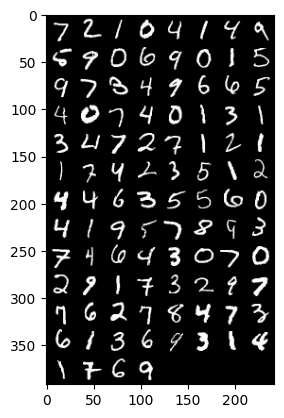

In [ ]:
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Print the actual labels
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(8)))

# Make predictions
outputs = model(images)

# Get the predicted class with the highest score
_, predicted = torch.max(outputs, 1)

# Print the predicted labels
print('Predicted: ', ' '.join('%5s' % predicted[j].item() for j in range(8)))

# Show images
# Unnormalize the images and make a grid
images_grid = torchvision.utils.make_grid(images.cpu(), nrow=8, normalize=True)
imshow(images_grid)


# Summary of the appraoch to get a convergence for the Fixed Point Layer as demonstrated above

Lets first see what we are doing in practice
1. We are effectively running a very deep network of 50+ layers in practice
  1. this can be thought of finding the parameters of the linear layers + tanh non-linearity while finding the solution to the equation z* = tanh(nn.linear(z*) + x)
  2. If we peak at 50 iterations, we are essentially solving 50 of these stacked layers together
  3. we re-add the input to our layer at each iteration z:=tanh(Wz+x)
2. The method demonstrated above is a simple iterative process with some significant limitations

**Limitations**
1. We gend up running the fixed point iteration for a large number of layers to get convergence within tolerance = 1e-4 of a fixed point
2. To be investigated, but individual iterations required for each mini-batch, several of them don't even reach tolerance levels and exit in less than max_iter steps
  1. its possible that the fixed point iterations become unstable at some points during training
  2. this can degrade the model significantly if proper error handling is not in place

**Bright-side**
1. `One benefit of Implicit layers is that they **provide a seperation between what is computed by the layer, and how the layer is computed**`
2. This means we can experiment with new ideas to finding the root of the equation, such as the Newton's method

# **Next**
 In ch1.1 Deep Implicit Layer - Fixedpoint through NewtonRootFinding.ipynb